# Clustering Assignment

### Import Module

In [1]:
# Data Wrangling
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

# Visualization
import matplotlib
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline

# EDA
import klib
import missingno as msno

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.base import ClassifierMixin

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# Clustering
from sklearn.cluster import *
from kneed import KneeLocator
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score


# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm, tqdm_notebook
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

### Read Data

In [2]:
import pandas as pd
data = pd.read_csv("Mall_Customers.csv", index_col = 0)
data.reset_index(inplace=True)
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [ ]:
for i in range(len(data.columns)):
    print(data.columns[i])
    print(data[data.columns][o])

## Missing Values

<AxesSubplot:>

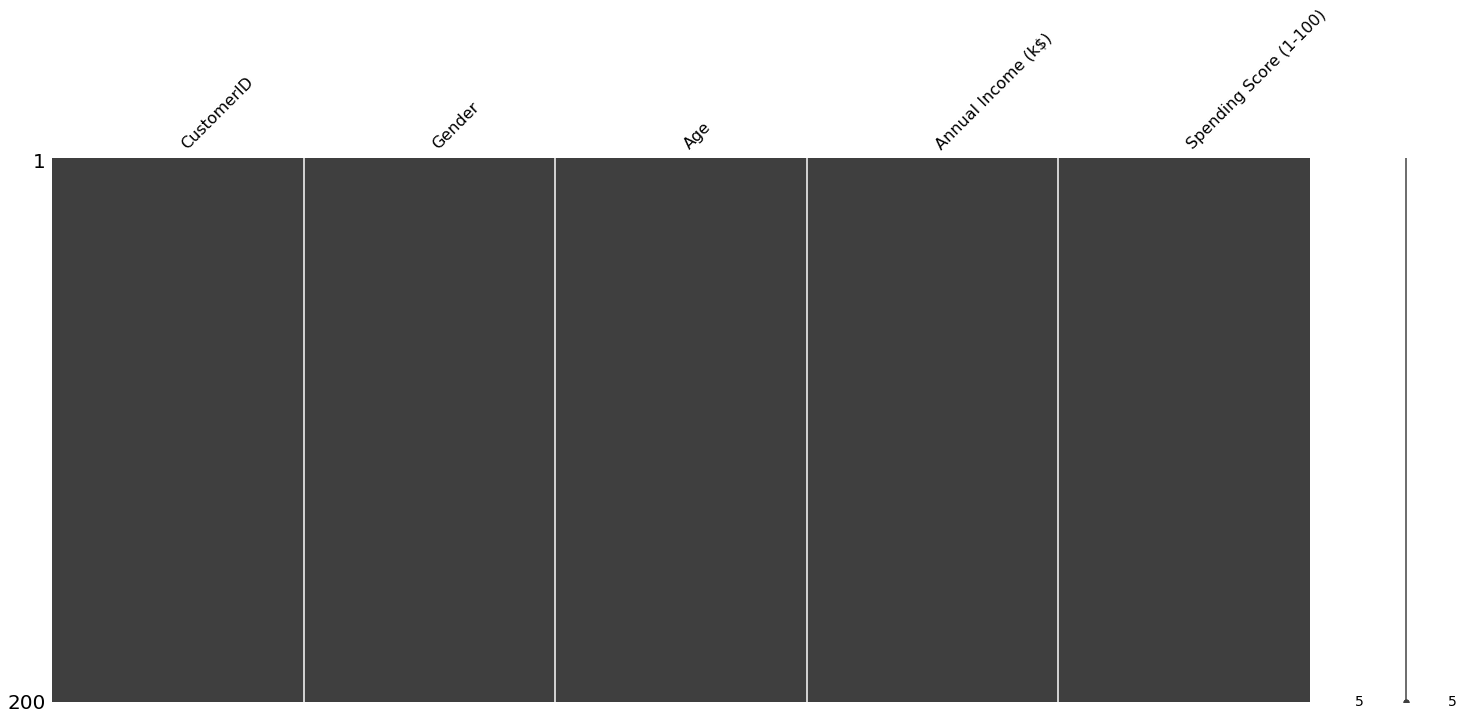

In [5]:
import missingno as msno

msno.matrix(data)

##### 결측치 없음

## EDA

In [6]:
colors = sns.color_palette('viridis')[1:]

def count_plot(feature):
    plt.figure(figsize=(6,4))
    s = sns.countplot(data = data, x = feature, palette='viridis')
    s.set_title(f"{feature} Distribution")
    plt.show()
    
    
def pie_plot(feature):
    data[feature].value_counts().plot.pie(autopct = "%.1f%%",colors = colors)
    plt.show()

def box_plot(feature):
    sns.boxplot(x = 'Gender', y = feature, data = data, palette='viridis', linewidth= 2)
    plt.show()
    
def hist_plot(feature):
    plt.hist(data[feature], bins = 'fd', density = True)
    data[feature].plot.density()
    plt.show()

#### catergorical variable

#### gender

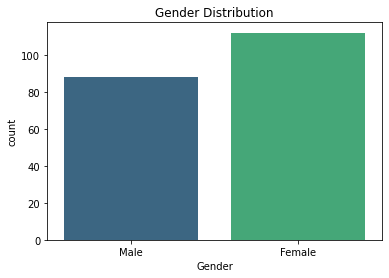

In [7]:
count_plot('Gender')

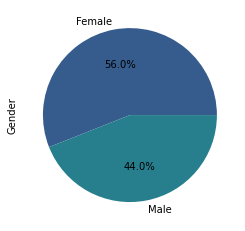

In [8]:
pie_plot('Gender')

##### female이 더 많음 

#### Numerical Variable

#### Age

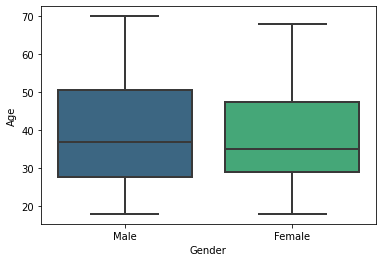

In [9]:
box_plot('Age')

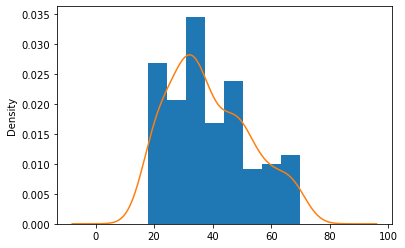

In [10]:
hist_plot('Age')

###### 30대가 제일 많음.

#### Annual Income (k$)

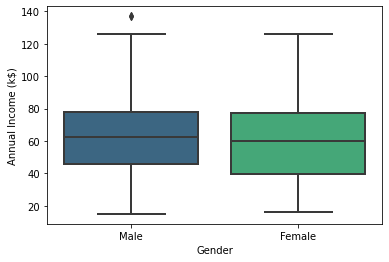

In [11]:
box_plot('Annual Income (k$)')

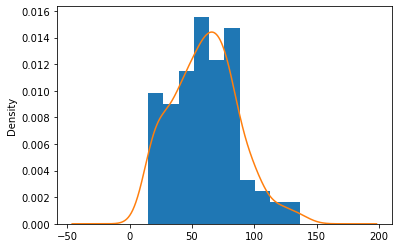

In [12]:
hist_plot('Annual Income (k$)')

##### 60에 가장 많이 분포되어 있음.

#### Spending Score (1-100)

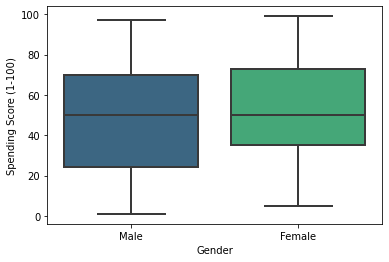

In [13]:
box_plot('Spending Score (1-100)')

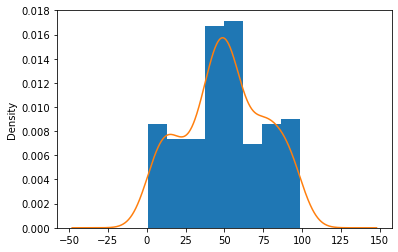

In [14]:
hist_plot('Spending Score (1-100)')

##### 50에 가장 많이 분포.
##### 정규분포를 띠고 있음.

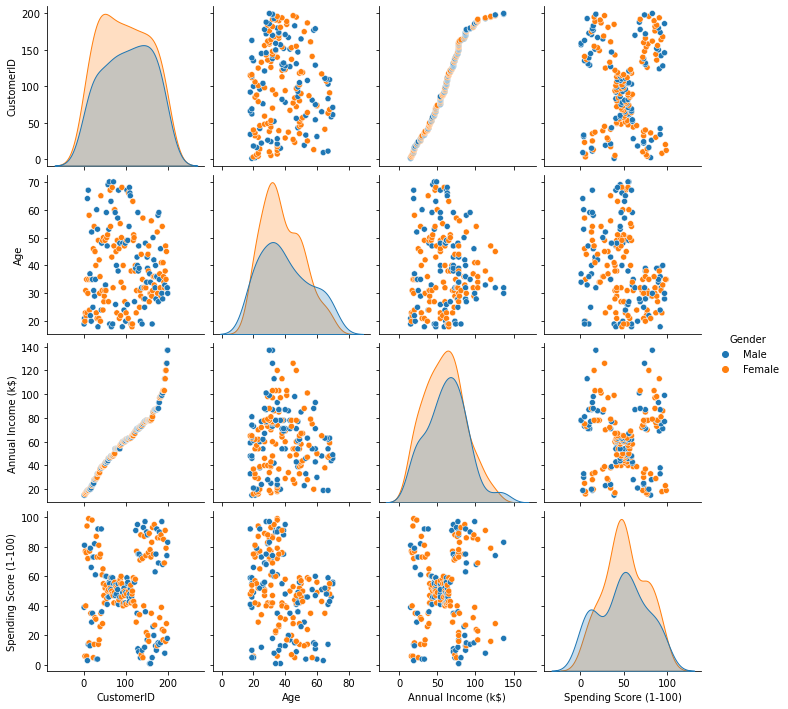

In [15]:
sns.pairplot(data, hue = 'Gender')
plt.show()

#### - pairplot의 결과를 보면 Annual Income과 Spending Score의 5개의 군집으로 나눌 수 있어보임.

## Data Preprocessing

#### Encode Categorical Variable

In [16]:
encoder = OneHotEncoder().fit(data[['Gender']])
encoder.get_feature_names(['Gender'])

array(['Gender_Female', 'Gender_Male'], dtype=object)

In [17]:
encoded_data =  pd.DataFrame(encoder.transform(data[['Gender']]).toarray(), index = data.index,
                             columns = encoder.get_feature_names(['Gender'])) 

data = pd.concat([data, encoded_data], sort = False, axis = 1).drop(['Gender'], axis = 1)
data

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
0,1,19,15,39,0.0,1.0
1,2,21,15,81,0.0,1.0
2,3,20,16,6,1.0,0.0
3,4,23,16,77,1.0,0.0
4,5,31,17,40,1.0,0.0
...,...,...,...,...,...,...
195,196,35,120,79,1.0,0.0
196,197,45,126,28,1.0,0.0
197,198,32,126,74,0.0,1.0
198,199,32,137,18,0.0,1.0


### Clustering Algorithm

## K-mean clustering
- data를 k개로 묶는 알고리즘
- 가장 단순하고 빠른 방법

##### 적절한 k?
- Rule of Thumb : K = $\sqrt{N/2}$
- Elbow Method : Within group 그래프에서 기울기가 완만해지는 곳
##### Annual Income과 Spending Score를 10개로 묶어서 진행.
##### 먼저 이 군집의 수가 Elbow Point에 들어가는지 먼저 확인.

In [18]:
data1 = data[['Annual Income (k$)', 'Spending Score (1-100)']]
data1

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40
...,...,...
195,120,79
196,126,28
197,126,74
198,137,18


scaling

In [19]:
scaler = StandardScaler()
scaler.fit(data1)
data1 = pd.DataFrame(scaler.transform(data1))
data1

,0,1
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913
3,-1.700830,1.040418
4,-1.662660,-0.395980
...,...,...
195,2.268791,1.118061
196,2.497807,-0.861839
197,2.497807,0.923953
198,2.917671,-1.250054


#### Elbow Method

- SSE값을 cluster의 개수를 두고 비교를 한 그래프를 통해 급격한 경사를 보이다가 완만한 경사를 보이는 부분에 해당하는 클러스터를 선택하는 기법 (elbow method)을 통해 최적의 k를 구하는 기법

In [20]:
def elbow_method(K, data):
    SSE = []
    k = 1
    while 1 <= k <= K: ### 1부터 K까지의 클러스터의 개수
        k_means = KMeans(n_clusters = k)
        k_means.fit(data1)
        SSE.append(k_means.inertia_)
        k += 1
    plt.plot(range(1, K+1), SSE, 'o')
    plt.plot(range(1, K+1), SSE, '--')
    plt.xlabel('K')
    plt.ylabel('SSE')
    kn = KneeLocator(range(1, K+1), SSE, curve = 'convex', direction = 'decreasing')
    plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles= 'dashed')
    return SSE

[399.99999999999994,
 269.01679374906655,
 157.70400815035939,
 108.92131661364358,
 65.56840815571681,
 55.103778121150555,
 44.86475569922555,
 37.148116972291106,
 32.34583777956662]

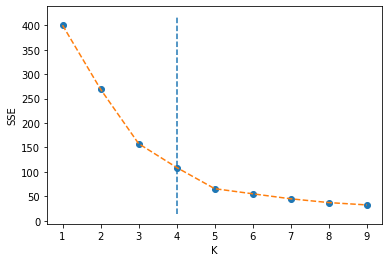

In [21]:
elbow_method(K = 9, data = data1)

##### 최적의 k값은 4로 나타남.

### K = 4

In [23]:
k_means = KMeans(n_clusters = 4).fit(data1)

data['k=4'] = k_means.labels_

data

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male,k=4
0,1,19,15,39,0.0,1.0,3
1,2,21,15,81,0.0,1.0,1
2,3,20,16,6,1.0,0.0,3
3,4,23,16,77,1.0,0.0,1
4,5,31,17,40,1.0,0.0,3
...,...,...,...,...,...,...,...
195,196,35,120,79,1.0,0.0,2
196,197,45,126,28,1.0,0.0,0
197,198,32,126,74,0.0,1.0,2
198,199,32,137,18,0.0,1.0,0


k = 4로 clustering 했을 때, 각 행이 어느 군집에 속하는지 dataframe에 추가

#### EDA

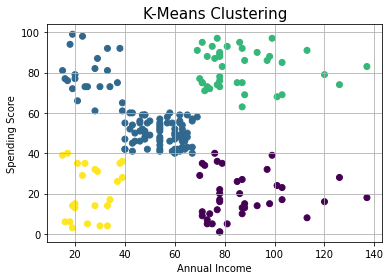

In [26]:
plt.title('K-Means Clustering', fontsize = 15)
plt.scatter(data['Annual Income (k$)'], data['Spending Score (1-100)'], c = data['k=4'])
plt.xlabel('Annual Income', fontsize = 10)
plt.ylabel('Spending Score', fontsize = 10)
plt.grid()
plt.show()

- Annual Income = 60, Spending Score = 40을 기준으로 군집화

### K = 5

In [27]:
k_means = KMeans(n_clusters = 5).fit(data1)

data['k=5'] = k_means.labels_
data

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male,k=4,k=5
0,1,19,15,39,0.0,1.0,3,3
1,2,21,15,81,0.0,1.0,1,1
2,3,20,16,6,1.0,0.0,3,3
3,4,23,16,77,1.0,0.0,1,1
4,5,31,17,40,1.0,0.0,3,3
...,...,...,...,...,...,...,...,...
195,196,35,120,79,1.0,0.0,2,2
196,197,45,126,28,1.0,0.0,0,0
197,198,32,126,74,0.0,1.0,2,2
198,199,32,137,18,0.0,1.0,0,0


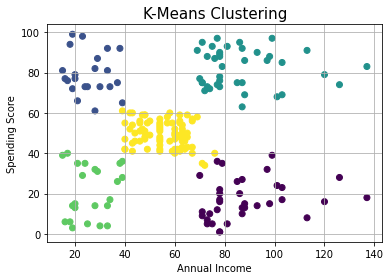

In [28]:
plt.title('K-Means Clustering', fontsize=15)
plt.scatter(data['Annual Income (k$)'], data['Spending Score (1-100)'], c = data['k=5'])
plt.xlabel('Annual Income', fontsize = 10)
plt.ylabel('Spending Score', fontsize = 10)
plt.grid()
plt.show()

- Annual Income = 40 ~ 65, Spending Score = 40 ~ 60으로 군집화

### Silhouette

- 군집을 만든 결과 얼마나 유용한지 따지는 군집타당성지표 중 하나
- 한 군집 내의 데이터들이 다른 군집과 비교해 얼마나 비슷한지를 나타내는 값
- 0~1값을 가지고 1에 가까울수록 군집과 멀리 떨어져있고 0에 가까울수록 근처 군집과 가깝다는 뜻

$S_i = {(b_i - a_i)\over\max(a_i, b_i)}$

$a_i$ = i번째 개체와 같은 군집에 속한 요소들 간 거리들의 평균
$b_i$ = i번째 개체와 다른 군집에 속한 요소들 간 거리들의 평균을 군집마다 각각 구한 뒤, 이 가운데 가장 작은 값
- 즉, i번째 개체가 속한 군집과 가장 근접한 군집간, 거리의 평균값

In [33]:
sample_4 = silhouette_samples(data, data['k=4'])
sample_5 = silhouette_samples(data, data['k=5'])

data['silhouette_k=4'] = sample_4
data['silhouette_k=5'] = sample_5

average_score_4 = silhouette_score(data, data['k=4'])
average_score_5 = silhouette_score(data, data['k=5'])

print('K = 4, silhouette : {0:.3f}'.format(average_score_4))
print('K = 5, silhouette : {0:.3f}'.format(average_score_5))

K = 4, silhouette : 0.351
K = 5, silhouette : 0.440


- k = 5일때 silhouette의 계수가 더 높음

## Hierarchical Clustering
- 여러개의 군집에서 가장 유사도 높은 군집을 두개 선택하여 하나로 합치면서 군집을 방법
- Hierarchical Clustering은 사전에 군집의 개수를 정하지 않아도 됨
- 군집 간의 거리 측정 : Ward's Method

$d(u,v) = \sqrt{{|v| + |s|\over T}d(v,s)^2 + {|v|+|s| \over T}d(v,t)^2 - {|v|\over T}d(s,t)^2} $

In [29]:
data1 
## Annual Income, Spending Score

,0,1
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913
3,-1.700830,1.040418
4,-1.662660,-0.395980
...,...,...
195,2.268791,1.118061
196,2.497807,-0.861839
197,2.497807,0.923953
198,2.917671,-1.250054


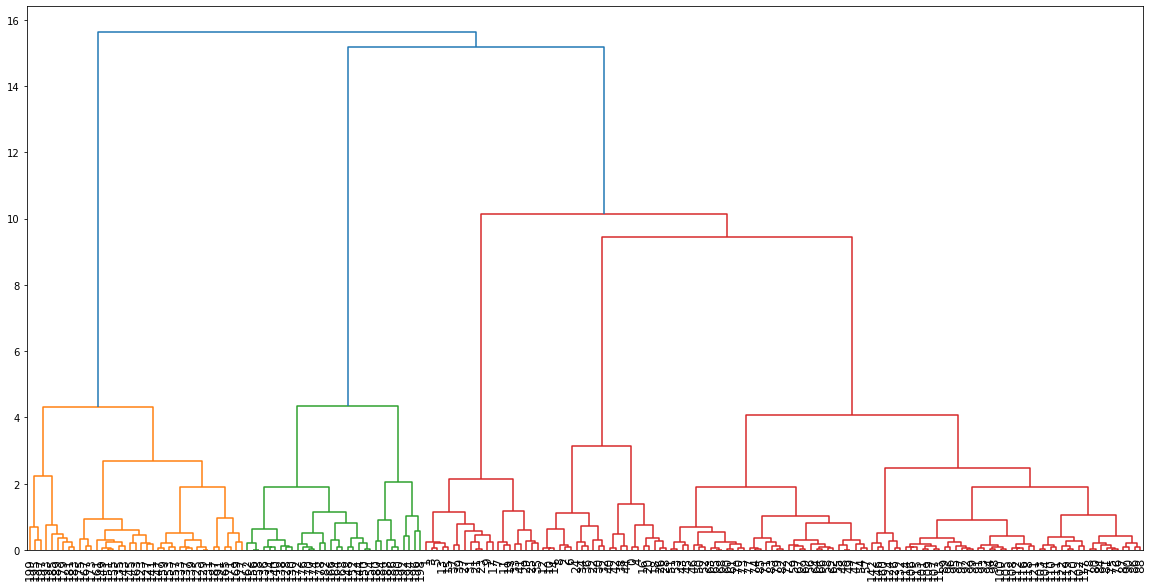

In [35]:
l1 = linkage(data1, method = 'ward')

plt.figure(figsize=(20, 10))
dendrogram(l1, leaf_font_size = 12, leaf_rotation = 90)
plt.show()

#### Agglomerative Clustering
- 병합 군집
- 각 하나의 클러스터를 지정하고 계속 비슷한 두 클러스터를 병합하는 알고리즘
- ward, max, average, minimum 

#### ward

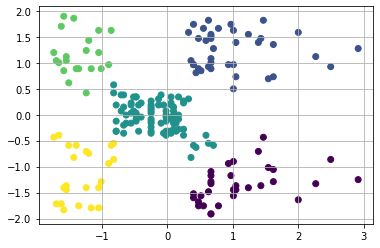

In [38]:
agg_ward = AgglomerativeClustering(n_clusters=5)
cluster_pred = agg_ward.fit_predict(data1)

## EDA

plt.scatter(data1[0], data1[1], c = cluster_pred)
plt.grid()
plt.show()

#### max

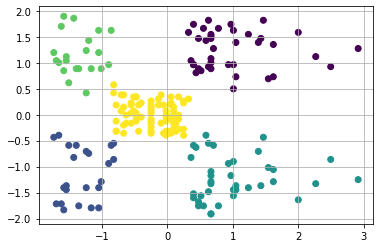

In [39]:
agg_max = AgglomerativeClustering(n_clusters=5, linkage = 'complete')
cluster_pred = agg_max.fit_predict(data1)

## EDA

plt.scatter(data1[0], data1[1], c = cluster_pred)
plt.grid()
plt.show()

#### average

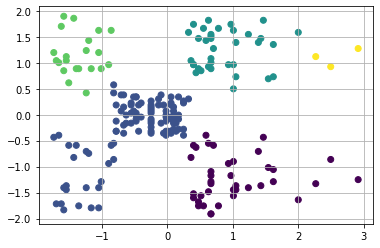

In [40]:
agg_av = AgglomerativeClustering(n_clusters=5, linkage = 'average')
cluster_pred = agg_av.fit_predict(data1)

## EDA

plt.scatter(data1[0], data1[1], c = cluster_pred)
plt.grid()
plt.show()

#### min

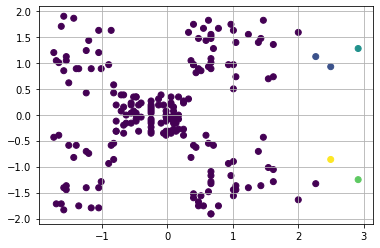

In [41]:
agg_min = AgglomerativeClustering(n_clusters=5, linkage = 'single')
cluster_pred = agg_min.fit_predict(data1)

## EDA

plt.scatter(data1[0], data1[1], c = cluster_pred)
plt.grid()
plt.show()

- ward와 max를 기준으로 clustering이 제일 잘 되어있는것을 확인할 수 있음.

### DBSCAN clustering
- 밀도 기반 군집화 알고리즘
- 높은 밀도를 가지고 모여 있는 값들을 하나의 그룹으로 보고 낮은밀도를 가지고 떨어져 있는 관측치들은 nosie로 분류
- 군집의 형태에 구애받지 않고, 군집의 개수를 지정할 필요 없음

In [51]:
db = DBSCAN(min_samples = 3)
predict = pd.DataFrame(db.fit_predict(data1))
predict.columns = ['DBSCAN']

db_pd = pd.concat([data1, predict], axis = 1)
db_pd

,0,1,DBSCAN_opt_labels,DBSCAN
0,-1.738999,-0.434801,0,0
1,-1.738999,1.195704,0,0
2,-1.700830,-1.715913,0,0
3,-1.700830,1.040418,0,0
4,-1.662660,-0.395980,0,0
...,...,...,...,...
195,2.268791,1.118061,0,-1
196,2.497807,-0.861839,0,-1
197,2.497807,0.923953,0,-1
198,2.917671,-1.250054,0,-1


In [42]:
dbscan_opt = DBSCAN(eps=30, min_samples=6)
dbscan_opt.fit(data1[[0,1]])

DBSCAN(eps=30, min_samples=6)

In [46]:
data['DBSCAN_opt_labels']=dbscan_opt.labels_
data['DBSCAN_opt_labels'].value_counts()

0    200
Name: DBSCAN_opt_labels, dtype: int64

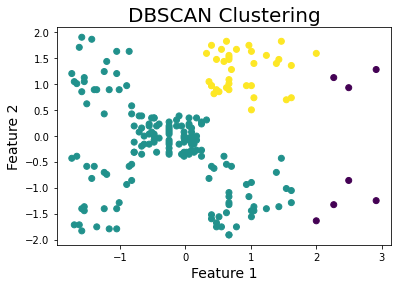

In [55]:
colors=['purple','red','blue','green']

plt.scatter(db_pd[0],db_pd[1],c=db_pd['DBSCAN'])
plt.title('DBSCAN Clustering',fontsize=20)
plt.xlabel('Feature 1',fontsize=14)
plt.ylabel('Feature 2',fontsize=14)
plt.show()

- 밀도가 높은 경우 하나의 그룹으로 분리하고 나머지는 별도의 그룹으로 clustering